In [1]:
from IPython.display import HTML
HTML('''
<script>
code_show=false;
function code_toggle(){
    if(code_show){$('.prompt, .input, .output_stderr, .output_error').hide();}
    else{$('.input, .prompt, .output_stderr, .output_error').show();}
    code_show=!code_show;
}
function initialize(){
    var output=$('.output_subarea.output_text.output_stream.output_stdout');
    $.merge(output,$('.output_subarea.output_text.output_result'));
    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)
        output[i].children[j].style.fontFamily='Palatino';
    code_toggle();
}
$(document).ready(initialize);
</script>
Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.
''')

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
from ipywidgets import interact, HTML

import plotly.graph_objects as go
import plotly

import matplotlib as mpl
print(mpl.__version__)

%load_ext tikzmagic

3.3.4
The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


# 2 Stage error propagation
$$
    y = tan^{-1}(x) \\
    z = sin(y) \\
$$
$$
    \frac{dy}{dx} = \frac{1}{1 + x^2} \\
    \frac{dz}{dy} = \cos(y)
$$
Error propagation:
$$
    \sigma_y = \left. \frac{dy}{dx}\right|_{\mu_x} \sigma_x \\
    \sigma_z = \left. \frac{dz}{dy}\right|_{\mu_y} \sigma_y
$$

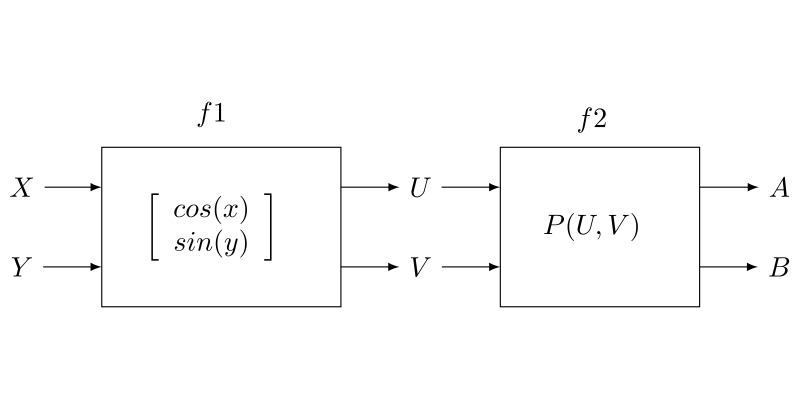

In [3]:
%%tikz -f svg -s 800,400 -l calc,positioning
\node (x) at (0,0) {$X$};
\node (y) at (0,-1) {$Y$};

\node (u) at (5, 0) {$U$};
\node (v) at (5,-1) {$V$};

\node (a) at (9.5, 0) {$A$};
\node (b) at (9.5, -1) {$B$};

\draw (1,-1.5) rectangle +(3,2);
\node[anchor=west,inner sep=15] (system1) at (1,-0.5) {$\left[\begin{array}{c}cos(x)\\sin(y)\end{array}\right]$};
\node[above=5pt of system1] {$f1$};
\draw (6,-1.5) rectangle +(2.5,2);
\node[anchor=west,inner sep=15] (system2) at (6, -0.5) {$P(U,V)$};
\node[above=10pt of system2] {$f2$};

\draw[-latex] (x) -- ($(x) + (1,0)$);
\draw[-latex] (y) -- ($(y) + (1,0)$);

\draw[-latex] ($(u) + (-1,0)$) -- (u);
\draw[-latex] ($(v) + (-1,0)$) -- (v);

\draw[-latex] (u) -- ($(u) + (1,0)$);
\draw[-latex] (v) -- ($(v) + (1,0)$);

\draw[latex-] (a) -- ($(a) + (-1,0)$);
\draw[latex-] (b) -- ($(b) + (-1,0)$);

$$
    P(U,V) = \left[ \begin{array}{c}
        \frac{1}{4}U^3 + \frac{1}{3}U^2 + U \\
        \frac{1}{4}V^3 + \frac{1}{3}V^2 + V
    \end{array} \right]
$$

$$
    J_1(x,y) = \left[ \begin{array}{cc}
        -\sin(x) & 0 \\
        0 & \cos(x)
    \end{array} \right] \\
    J_2(u,v) = \left[ \begin{array}{cc}
        \frac{3}{4}u^2 + \frac{1}{3}u + 1 & 0 \\
        0 & \frac{3}{4}v^2 + \frac{2}{3}v + 1
    \end{array} \right]
$$

$$
    \Sigma_{UV}(x,y) = J_1(x,y) ~ \Sigma_{AB} ~ J_1(x,y)^T \\
    \Sigma_{AB}(u,v) = J_2(u,v) ~ \Sigma_{UV} ~ J_2(u,v)^T
$$

# Influence of one stage to the outcome ($\rho = 0$)

\begin{align}
    \sigma_u^2 &= \left(\frac{ \delta cos(x) }{ \delta x }\right)^2 \sigma_x^2 & \sigma_v &= \left(\frac{ \delta sin(y) }{ \delta y }\right)^2 \sigma_y^2 \\
    \sigma_a^2 &= \left(\frac{ \delta P_U }{ \delta u }\right)^2 \left(\frac{ \delta cos(x) }{ \delta x }\right)^2 \sigma_x^2 & \sigma_b^2 &= \left(\frac{ \delta P_V }{ \delta v }\right)^2 \left(\frac{ \delta sin(y) }{ \delta y }\right)^2 \sigma_y^2
\end{align}

$$
    I_{1x} = \frac{ \log(m_{1x}) }{ \log( m_{1x} \cdot m_{2u} ) } \\
    I_{1y} = \frac{ \log(m_{1y}) }{ \log( m_{1y} \cdot m_{2v} ) } \\
$$

In [174]:
def f1(x, y):
    return np.array([
        np.cos(x),
        np.sin(y)
    ])
def J1(x, y):
    return np.array([
        [-np.sin(x), 0.0],
        [0.0, np.cos(y)]
    ])
def f2(u, v):
    return np.array([
        1/4*u**3 + 1/3*u**2 + u,
        1/4*v**3 + 1/3*v**2 + v
    ])
def J2(u,v):
    return np.array([
        [3/4*u**2 + 2/3*u + 1, 0],
        [0, 3/4*v + 2/3*v + 1]
    ])
def Sigma_uv(x,y, Sigma_xy):
    return J1(x,y) @ Sigma_xy @ J1(x,y).T
def Sigma_ab(u,v, Sigma_uv):
    return J2(u,v) @ Sigma_uv @ J2(u,v).T

def influence(J1, J2, dim=0):
    gradient1 = np.abs(J1[dim,dim])
    gradient2 = np.abs(J2[dim,dim])
    
    if gradient1 == 0:
        return 1.0
    elif gradient2 == 0:
        return 0.0
    
    if gradient1 == gradient2:
        return 0.5
    
    if gradient1 < 1 and gradient2 >= 1:
        return -np.log(gradient1) / (np.log( gradient2 ) - np.log(gradient1))
    elif gradient1 >=1 and gradient2 < 1:
        return np.log(gradient1) / (np.log( gradient1 ) - np.log(gradient2))
    else:
        return np.log(gradient1) / np.log( gradient1 * gradient2)

@interact(m1=(-np.pi, np.pi, 0.01), sigma1=(1e-9,1.0, 0.01), m2=(-np.pi, np.pi, 0.01), sigma2=(1e-9,1.0, 0.01), rho=(-1.0, 1.0, 0.1))
def show_linear(m1=0.0, sigma1=1.0, m2=0.0, sigma2=1.0, rho=0.0):
    x = np.linspace(-np.pi, np.pi)
    y = np.linspace(-np.pi, np.pi)
    
    xx, yy = np.meshgrid(x, y)
    
    uu, vv = f1(xx, yy)
    u, v = f1(m1, m2)
    
    S_uv = Sigma_uv(m1, m2, np.array([
        [sigma1**2, sigma1*sigma2*rho],
        [sigma1*sigma2*rho, sigma2**2]
    ]))
    
    aa, bb = f2(uu, vv)
    a, b = f2(u, v)
    
    S_ab = Sigma_uv(m1, m2, S_uv)
    
    I_1 = np.array([
        influence(J1(m1,m2), J2(u,v), 0),
        influence(J1(m1,m2), J2(u,v), 1)
    ])
    
    I_2 = np.array([
        influence(J2(u,v), J1(m1,m2), 0),
        influence(J2(u,v), J1(m1,m2), 1),
    ])
    
    ### Ploting ###
    
    spacing = 0.1
    left = 0.1
    bottom = 0.1
    
    f1_width = 0.5
    f1_height = 0.5
    S1_width = 0.5
    S1_height = f1_height
    f2_width = 0.5
    f2_height = 0.5
    S2_width = 0.5
    S2_height = f2_height
    
    rect_f1 = [left+spacing, bottom+spacing+f2_height+spacing, f1_width, f1_height]
    rect_f2 = [left+spacing, bottom+spacing, f2_width, f2_height]
    rect_S1 = [left+spacing+f1_width+spacing, bottom+spacing+f2_height+spacing, S1_width, S1_height]
    rect_S2 = [left+spacing+f1_width+spacing, bottom+spacing, S2_width, S2_height]
    rect_quiverkey_S1 = [left+spacing+f1_width+spacing+S1_width-2*spacing, bottom+spacing+f2_height+spacing+f1_height, 0.1, 0.05]
    rect_quiverkey_S2 = [left+spacing+f1_width+spacing+S1_width-2*spacing, bottom+spacing+f2_height, 0.1, 0.05]
    
    fig = plt.figure(figsize=(11,10))
    
    ax_f1 = fig.add_axes(rect_f1)
    ax_f2 = fig.add_axes(rect_f2)
    ax_S1 = fig.add_axes(rect_S1)
    ax_S2 = fig.add_axes(rect_S2)
    ax_quiverkey_S1 = fig.add_axes(rect_quiverkey_S1)
    ax_quiverkey_S1.set_axis_off()
    ax_quiverkey_S2 = fig.add_axes(rect_quiverkey_S2)
    ax_quiverkey_S2.set_axis_off()
    
    img_f1 = ax_f1.imshow(np.linalg.norm([uu,vv], axis=0), aspect='auto')
    ax_f1.set_xticks(np.linspace(0, len(x), 4))
    ax_f1.set_xticklabels([r'$-\pi$', r'$-\frac{1}{2}\pi$', r'$\frac{1}{2}\pi$', r'$\pi$'])
    ax_f1.set_yticks(np.linspace(0, len(y), 4))
    ax_f1.set_yticklabels([r'$-\pi$', r'$-\frac{1}{2}\pi$', r'$\frac{1}{2}\pi$', r'$\pi$'])
    ax_f1.vlines(m1/np.pi*len(x)/2 + len(x)/2, 0, len(y), ls='dashed', color='k')
    ax_f1.hlines(m2/np.pi*len(y)/2 + len(x)/2, 0, len(x), ls='dashed', color='k')
    ax_f1.set_xlim(0, len(x))
    ax_f1.set_ylim(0, len(y))
    
    ax_f1.set_xlabel('x')
    ax_f1.set_ylabel('y')
    cbar = plt.colorbar(img_f1, ax=ax_S1)
    cbar.set_label(r'$f_1(x,y)$')
    
    Q1 = ax_S1.quiver(0, 0, u, v, angles='xy', scale_units='xy', scale=1)
    Q1_std = ax_S1.quiver(0, 0, u+np.sqrt(S_uv[0,0]), v+np.sqrt(S_uv[1,1]), color='orange', angles='xy', scale_units='xy', scale=1)
    ax_S1.quiver(0, 0, u-np.sqrt(S_uv[0,0]), v-np.sqrt(S_uv[1,1]), color='orange', angles='xy', scale_units='xy', scale=1)
    ax_S1.set_xticks(np.linspace(-1.5,1.5,5))
    ax_S1.set_yticks(np.linspace(-1.5,1.5,5))
    ax_S1.set_title(r'$I_1 = ({:g},{:g})^T$'.format(*I_1))
    
    ax_quiverkey_S1.quiverkey(
        Q1,
        left+spacing+f1_width+spacing+S1_width-spacing-0.02,
        bottom+spacing+f2_height+spacing+f1_height+0.04,
        0.25, r'$f_1(x,y)$', labelpos='E', coordinates='figure')
    ax_quiverkey_S1.quiverkey(
        Q1_std,
        left+spacing+f1_width+spacing+S1_width-spacing-0.02,
        bottom+spacing+f2_height+spacing+f1_height+0.02,
        0.25, r'$f_1(x,y) \pm \sigma$', labelpos='E', coordinates='figure')
    
    img_f2 = ax_f2.contourf(uu, vv, np.linalg.norm([aa,bb], axis=0), 30)
    ax_f2.vlines(u, -1, 1, ls='dashed', color='k')
    ax_f2.hlines(v, -1, 1, ls='dashed', color='k')
    
    ax_f2.set_xlabel('u')
    ax_f2.set_ylabel('v')
    cbar = plt.colorbar(img_f2, ax=ax_S2)
    cbar.set_label(r'$f_2(u,v)$')
    
    Q2 = ax_S2.quiver(0, 0, a, b, angles='xy', scale_units='xy', scale=1)
    Q2_std = ax_S2.quiver(0, 0, a+np.sqrt(S_ab[0,0]), b+np.sqrt(S_ab[1,1]), color='orange', angles='xy', scale_units='xy', scale=1)
    ax_S2.quiver(0, 0, a-np.sqrt(S_ab[0,0]), b-np.sqrt(S_ab[1,1]), color='orange', angles='xy', scale_units='xy', scale=1)
    ax_S2.set_xticks(np.linspace(-2,2,5))
    ax_S2.set_yticks(np.linspace(-2,2,5))
    ax_S2.set_title(r'$I_2 = ({:g},{:g})^T$'.format(*I_2))
    
    ax_quiverkey_S2.quiverkey(
        Q2,
        left+spacing+f1_width+spacing+S1_width-spacing-0.02,
        bottom+spacing+f2_height+0.04,
        0.25, r'$f_2(u,v)$', labelpos='E', coordinates='figure')
    ax_quiverkey_S2.quiverkey(
        Q2_std,
        left+spacing+f1_width+spacing+S1_width-spacing-0.02,
        bottom+spacing+f2_height+0.02,
        0.25, r'$f_2(u,v) \pm \sigma$', labelpos='E', coordinates='figure')
    
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='m1', max=3.141592653589793, min=-3.141592653589793, …

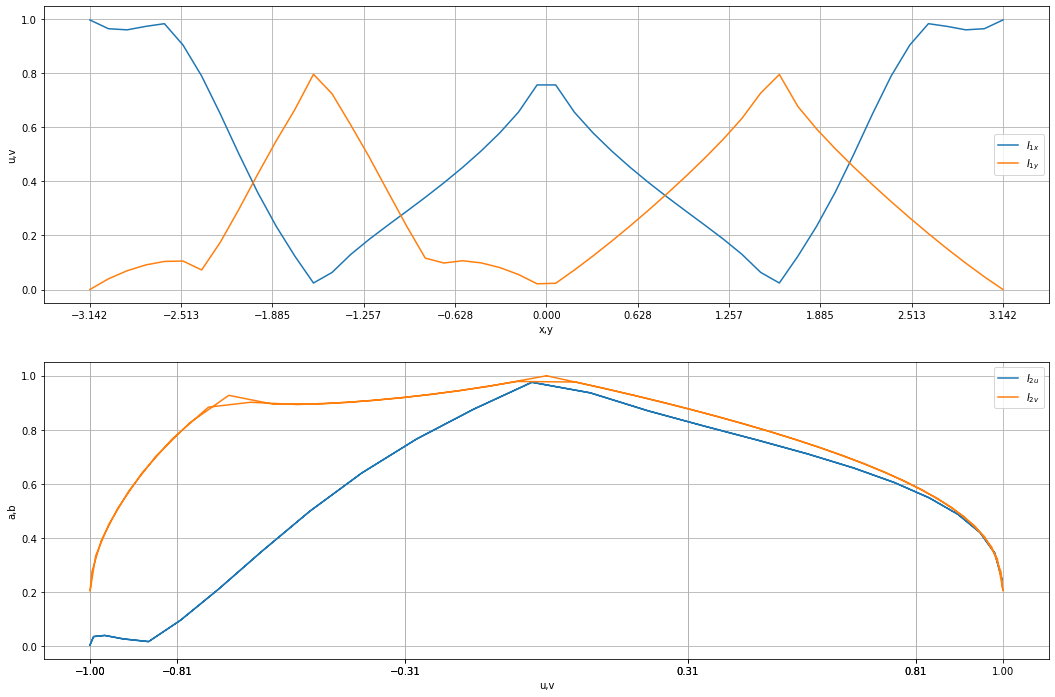

In [202]:
x = np.linspace(-np.pi, np.pi)
y = np.linspace(-np.pi, np.pi)

u, v = f1(x,y)

I_1 = np.array([
    [influence(J1(i,0), J2(k,0), 0) for i,k in zip(x,u)],
    [influence(J1(0,j), J2(0,l), 1) for j,l in zip(y,v)]
])

I_2 = np.array([
    [influence(J2(k,0), J1(i,0), 0) for i,k in zip(x,u)],
    [influence(J2(0,l), J1(0,j), 1) for j,l in zip(y,v)]
])

ticks_x = np.linspace(-np.pi, np.pi, 11)
ticks_u = np.array([f1(i,0) for i in ticks_x])

plt.figure(figsize=(18,12))
plt.subplot(2,1,1)
plt.plot(x, I_1[0], label='$I_{1x}$')
plt.plot(y, I_1[1], label='$I_{1y}$')
plt.xticks(ticks_x)
plt.xlabel('x,y')
plt.ylabel('u,v')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.plot(u, I_2[0], label='$I_{2u}$')
plt.plot(v, I_2[1], label='$I_{2v}$')
plt.xticks(ticks_u[:,0])
plt.xlabel('u,v')
plt.ylabel('a,b')
plt.grid()
plt.legend()

plt.show()

## Embedding everything in one picture

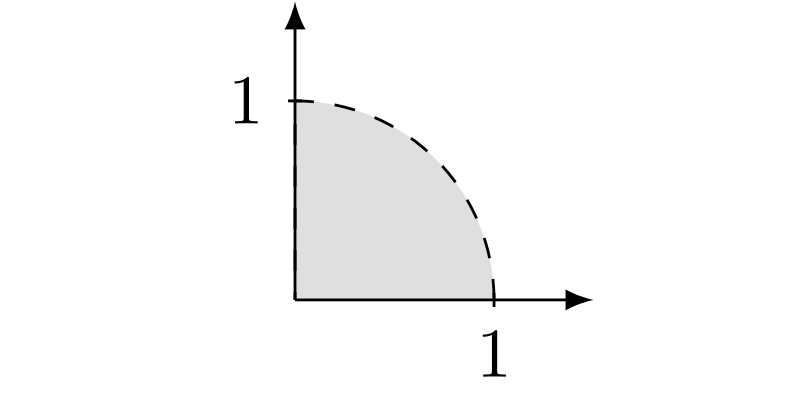

In [233]:
%%tikz %%tikz -f svg -s 800,400 -l calc,positioning

\draw[fill=gray!25,dashed] (1,0) arc (0:90:1) -- (0,0);
\draw[-latex] (0,0) -- (1.5,0);
\draw[-latex] (0,0) -- (0,1.5);

\draw (1,1pt) -- (1,-1pt) node[below] {$1$};
\draw (1pt,1) -- (-1pt,1) node[left] {$1$};
